# `Project Dependencies`

In [2]:
!pip install transformers
!pip install sentencepiece
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00


# `Project Code`

Updated Project Code With detokenisation

In [6]:
from transformers import AutoTokenizer
from datasets import load_dataset
import time

# byte_pair_tokenization = ["openai-gpt", "gpt2", "NousResearch/Llama-2-13b-hf"]
# unigram_tokenization = ["google/bigbird-roberta-base", "facebook/mbart-large-50-many-to-many-mmt" , "albert-base-v2" , "xlnet-base-cased"]
# wordpiece_tokenization = ['distilbert-base-uncased','google/mobilebert-uncased','funnel-transformer/small-base','sentence-transformers/all-mpnet-base-v2']
# sentencepiece_tokenization = ["google/flan-t5-base"]

#corpus = ["I have a new GPU!", "I wonder how fast the model will train on this.","Hello there"]

dataset = load_dataset("HuggingFaceH4/self-instruct-seed")
corpus = dataset['train']['instruction']
dataset2 = load_dataset("fka/awesome-chatgpt-prompts")
corpus2 = dataset2['train']['prompt']

def initialize_model(model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return tokenizer

#Unbatched data
def time_model(tokenizer_object, text, tokenize=True):
    if tokenize:
        # Capture the start time
        start_time = time.time()
        tokenizer_object.encode_plus(text)
    else:
        tokens = tokenizer_object.encode_plus(text)
        # Capture the start time
        start_time = time.time()
        tokenizer_object.decode(tokens['input_ids'], skip_special_tokens=True)

    # Capture the end time
    end_time = time.time()
    # Calculate the elapsed time in milliseconds
    elapsed_time = (end_time - start_time) * 1e3
    return elapsed_time

def analyse_encode_plus(tokenizers: list, corpus: list) -> dict:
    results = {}
    results['method'] = "Unbatched"

    for hugging_face_tokenizer in tokenizers:
        try:
            tokenizer = initialize_model(hugging_face_tokenizer)
            total_time_tokenization = 0  # Total time for tokenization
            total_time_detokenization = 0  # Total time for detokenization

            for text in corpus:
                # Tokenize each line in the corpus individually
                tokenization_time = time_model(tokenizer, text, tokenize=True)
                total_time_tokenization += tokenization_time

                # Detokenize the encoded text
                detokenization_time = time_model(tokenizer, text, tokenize=False)
                total_time_detokenization += detokenization_time

            # Extract tokenizer name or path for dictionary key
            tokenizer_name = tokenizer.name_or_path
            results[tokenizer_name] = {
                "Tokenization": total_time_tokenization,
                "Detokenization": total_time_detokenization
            }

            print(f"{tokenizer_name}:")
            print(f"Tokenization Time: {total_time_tokenization} ms")
            print(f"Detokenization Time: {total_time_detokenization} ms")
        except Exception as e:
            print(f"Error occurred for {hugging_face_tokenizer}: {e}")
            continue

    return results

def time_model_batch(tokenizer, corpus,tokenize=True):

    if tokenize:
        # Capture the start time
        start_time = time.time()
        tokenizer.batch_encode_plus(corpus)
    else:
        tokens = tokenizer.batch_encode_plus(corpus)
        # Capture the start time
        start_time = time.time()
        tokenizer.batch_decode(tokens['input_ids'], skip_special_tokens=True)

    # Capture the end time
    end_time = time.time()
    # Calculate the elapsed time in milliseconds
    elapsed_time = (end_time - start_time) * 1e3
    return elapsed_time

def analyse_batch(tokenizers: list, corpus: list) -> dict:
    results = {}
    results['method'] = "Batched"
    for hugging_face_tokenizer in tokenizers:
        tokenizer = initialize_model(hugging_face_tokenizer)
        try:
            #get time for tokenization
            tokenization_time = time_model_batch(tokenizer, corpus, tokenize=True)
            #get time for detokenization
            detokenization_time = time_model_batch(tokenizer, corpus,tokenize=False)

            # Extract tokenizer name or path for dictionary key
            tokenizer_name = tokenizer.name_or_path
            results[tokenizer_name] = {
                "Tokenization": tokenization_time,
                "Detokenization": detokenization_time
            }

            print(f"{tokenizer_name}:")
            print(f"Tokenization Time: {tokenization_time} ms")
            print(f"Detokenization Time: {detokenization_time} ms")
        except Exception as e:
          print(f"Error occured for {hugging_face_tokenizer}: {e}")
          continue

    return results


In [7]:
byte_pair = ["openai-gpt", "gpt2", "NousResearch/Llama-2-13b-hf"]
print("--------------------------Unbatched Data-------------------------------")
byte_pair_timing_unbatched = analyse_encode_plus(byte_pair, corpus)
print("--------------------------Batched Data-------------------------------")
byte_pair_timing_batched = analyse_batch(byte_pair,corpus)

--------------------------Unbatched Data-------------------------------


openai-gpt:
Tokenization Time: 43.86401176452637 ms
Detokenization Time: 4636.638402938843 ms


gpt2:
Tokenization Time: 28.963804244995117 ms
Detokenization Time: 30.27176856994629 ms


NousResearch/Llama-2-13b-hf:
Tokenization Time: 23.947477340698242 ms
Detokenization Time: 33.84041786193848 ms
--------------------------Batched Data-------------------------------
openai-gpt:
Tokenization Time: 12.437582015991211 ms
Detokenization Time: 27.917861938476562 ms
gpt2:
Tokenization Time: 11.896848678588867 ms
Detokenization Time: 21.71921730041504 ms
NousResearch/Llama-2-13b-hf:
Tokenization Time: 10.356903076171875 ms
Detokenization Time: 25.433063507080078 ms


In [8]:
# Get response time for word_piece models
word_piece =['distilbert-base-uncased','google/mobilebert-uncased','funnel-transformer/small-base','sentence-transformers/all-mpnet-base-v2']
print("--------------------------Unbatched Data-------------------------------")
word_piece_timing_unbatched = analyse_encode_plus(word_piece, corpus)
print("--------------------------Batched Data-------------------------------")
word_piece_timing_batched = analyse_batch(word_piece,corpus)

--------------------------Unbatched Data-------------------------------


distilbert-base-uncased:
Tokenization Time: 21.96478843688965 ms
Detokenization Time: 30.92503547668457 ms


google/mobilebert-uncased:
Tokenization Time: 21.3472843170166 ms
Detokenization Time: 30.184507369995117 ms


funnel-transformer/small-base:
Tokenization Time: 39.96157646179199 ms
Detokenization Time: 56.79798126220703 ms


sentence-transformers/all-mpnet-base-v2:
Tokenization Time: 44.05856132507324 ms
Detokenization Time: 63.51518630981445 ms
--------------------------Batched Data-------------------------------
distilbert-base-uncased:
Tokenization Time: 24.7805118560791 ms
Detokenization Time: 55.0227165222168 ms
google/mobilebert-uncased:
Tokenization Time: 16.29805564880371 ms
Detokenization Time: 50.14324188232422 ms
funnel-transformer/small-base:
Tokenization Time: 16.50524139404297 ms
Detokenization Time: 48.596858978271484 ms
sentence-transformers/all-mpnet-base-v2:
Tokenization Time: 16.884565353393555 ms
Detokenization Time: 48.87819290161133 ms


In [9]:
sentence_piece = ["google/flan-t5-base"]
sentence_piece_timing_unbatched = analyse_encode_plus(sentence_piece, corpus)
sentence_piece_timing_batched = analyse_batch(sentence_piece,corpus)

google/flan-t5-base:
Tokenization Time: 26.16095542907715 ms
Detokenization Time: 27.93097496032715 ms
google/flan-t5-base:
Tokenization Time: 13.252496719360352 ms
Detokenization Time: 25.762319564819336 ms


In [10]:
unigram = ["google/bigbird-roberta-base", "facebook/mbart-large-50-many-to-many-mmt" , "albert-base-v2" , "xlnet-base-cased"]
print("--------------------------Unbatched Data-------------------------------")
unigram_timing_unbatched = analyse_encode_plus(unigram, corpus)
print("--------------------------Batched Data-------------------------------")
unigram_timing_batched = analyse_batch(unigram,corpus)

--------------------------Unbatched Data-------------------------------


google/bigbird-roberta-base:
Tokenization Time: 41.922807693481445 ms
Detokenization Time: 47.985076904296875 ms


facebook/mbart-large-50-many-to-many-mmt:
Tokenization Time: 75.96659660339355 ms
Detokenization Time: 29.387235641479492 ms


albert-base-v2:
Tokenization Time: 32.01627731323242 ms
Detokenization Time: 28.39827537536621 ms


xlnet-base-cased:
Tokenization Time: 32.401323318481445 ms
Detokenization Time: 28.598546981811523 ms
--------------------------Batched Data-------------------------------
google/bigbird-roberta-base:
Tokenization Time: 19.152402877807617 ms
Detokenization Time: 26.4129638671875 ms
facebook/mbart-large-50-many-to-many-mmt:
Tokenization Time: 13.997793197631836 ms
Detokenization Time: 25.593996047973633 ms
albert-base-v2:
Tokenization Time: 17.01641082763672 ms
Detokenization Time: 28.77521514892578 ms
xlnet-base-cased:
Tokenization Time: 15.417098999023438 ms
Detokenization Time: 29.669523239135742 ms


In [4]:
from transformers import M2M100ForConditionalGeneration, AutoTokenizer

def translate(corpus,language):
    # Load the pre-trained model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained("facebook/m2m100_418M", src_lang="en")
    model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M")

    # Initialize an empty list to store the translated sentences
    translated_corpus = []

    # Loop through each sentence in the input corpus
    for sentence in corpus:
        # Tokenize and encode the English sentence
        encoded_en = tokenizer(sentence, return_tensors="pt")

        # Generate the translation to Chinese
        generated_tokens = model.generate(**encoded_en, forced_bos_token_id=tokenizer.get_lang_id(language))

        # Decode the generated tokens back to text
        translated_sentence = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

        #Print translated_sentence
        print(translated_sentence)

        # Append the translated sentence to the result list
        translated_corpus.append(translated_sentence)

    return translated_corpus

chinese_corpus = translate(corpus2,"zh")


# # decodes the translated tokens
# zh_text = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

我希望你作为一个Linux终端行动,我会输入命令,你会回答什么终端应该显示,我希望你只用终端输出在一个独特的代码块内回复,没有别的东西,不要写解释,不要输入命令,除非我指示你这样做。
我希望你作为一个英语翻译者,演讲纠正者和改进者,我会用任何语言对你说话,你会发现语言,翻译它,并在我的文本的改进和改进版本中回答,在英语。我希望你用更美丽、更优雅、更高级的英语词语和句子替换我的简化A0级词语和句子。保持意义相同,但使它们更文学。我希望你只回答纠正,改进和其他任何东西,不要写解释。
我希望你作为面试者行动,我将成为候选人,你会问我面试问题为“位置”的位置,我希望你只是作为面试者回答,不要写所有的保留,我希望你只是与我进行面试,问我问题,等待我的答案,不要写解释,问我一个问题,一个问题,一个问题,一个问题,一个问题,一个问题,一个问题,一个问题,一个问题。
我希望你作为一个JavaScript控制台工作,我会输入命令,你会用什么JavaScript控制台应该显示的回复,我希望你只有在一个独特的代码块内输出终端回复,没有别的东西,不要写解释,不要输入命令,除非我指示你这样做。
我希望你作为一个基于文本的Excel行动. 你只会回答我基于文本的10行Excel表与序列数字和单元格字母作为列(A到L)。 第一列标题应该是空的参考序列号. 我会告诉你什么写在单元格,你只会回答Excel表作为文本的结果,没有别的。 不要写解释. 我会写你公式,你会执行公式,你只会回答Excel表作为文本的结果。
我希望你作为土耳其语的人的英语发音助理,我会为你写句子,你只会回答他们的发音,没有别的。 答案不应该是我的发音的翻译,而只是发音。 发音应该使用土耳其语拉丁字母为语音。 不要写答案的解释。 我的第一句是“天气如何在伊斯坦布尔?”
我希望你作为一个发音的英语教师和改进者,我会用英语对你说话,你会用英语回答我练习我的发音的英语,我希望你保持你的答案清晰,限制答案到100字,我希望你严格纠正我的语法错误,类型和事实错误,我希望你在你的答案中问我一个问题,现在让我们开始练习,你可以先问我一个问题,记住,我希望你严格纠正我的语法错误,类型和事实错误。
我希望你作为一个旅行指南,我会写我的位置,你会建议一个地方去附近我的位置,在某些情况下,我也会给你我会去的地方类型,你也会建议我类似的地方,接近我的第

In [5]:
# Save the translations to a text file
with open("corpus_2_chinese.txt", "w", encoding="utf-8") as file:
    for translation in chinese_corpus:
        file.write(translation + "\n")

print("Translations saved to 'corpus_2_chinese.txt'.")

Translations saved to 'corpus_2_chinese.txt'.


In [11]:
print(byte_pair_timing_unbatched)
print(byte_pair_timing_batched)
print(word_piece_timing_unbatched)
print(word_piece_timing_batched)
print(sentence_piece_timing_unbatched)
print(sentence_piece_timing_batched)
print(unigram_timing_unbatched)
print(unigram_timing_batched)

{'method': 'Unbatched', 'openai-gpt': {'Tokenization': 43.86401176452637, 'Detokenization': 4636.638402938843}, 'gpt2': {'Tokenization': 28.963804244995117, 'Detokenization': 30.27176856994629}, 'NousResearch/Llama-2-13b-hf': {'Tokenization': 23.947477340698242, 'Detokenization': 33.84041786193848}}
{'method': 'Batched', 'openai-gpt': {'Tokenization': 12.437582015991211, 'Detokenization': 27.917861938476562}, 'gpt2': {'Tokenization': 11.896848678588867, 'Detokenization': 21.71921730041504}, 'NousResearch/Llama-2-13b-hf': {'Tokenization': 10.356903076171875, 'Detokenization': 25.433063507080078}}
{'method': 'Unbatched', 'distilbert-base-uncased': {'Tokenization': 21.96478843688965, 'Detokenization': 30.92503547668457}, 'google/mobilebert-uncased': {'Tokenization': 21.3472843170166, 'Detokenization': 30.184507369995117}, 'funnel-transformer/small-base': {'Tokenization': 39.96157646179199, 'Detokenization': 56.79798126220703}, 'sentence-transformers/all-mpnet-base-v2': {'Tokenization': 44

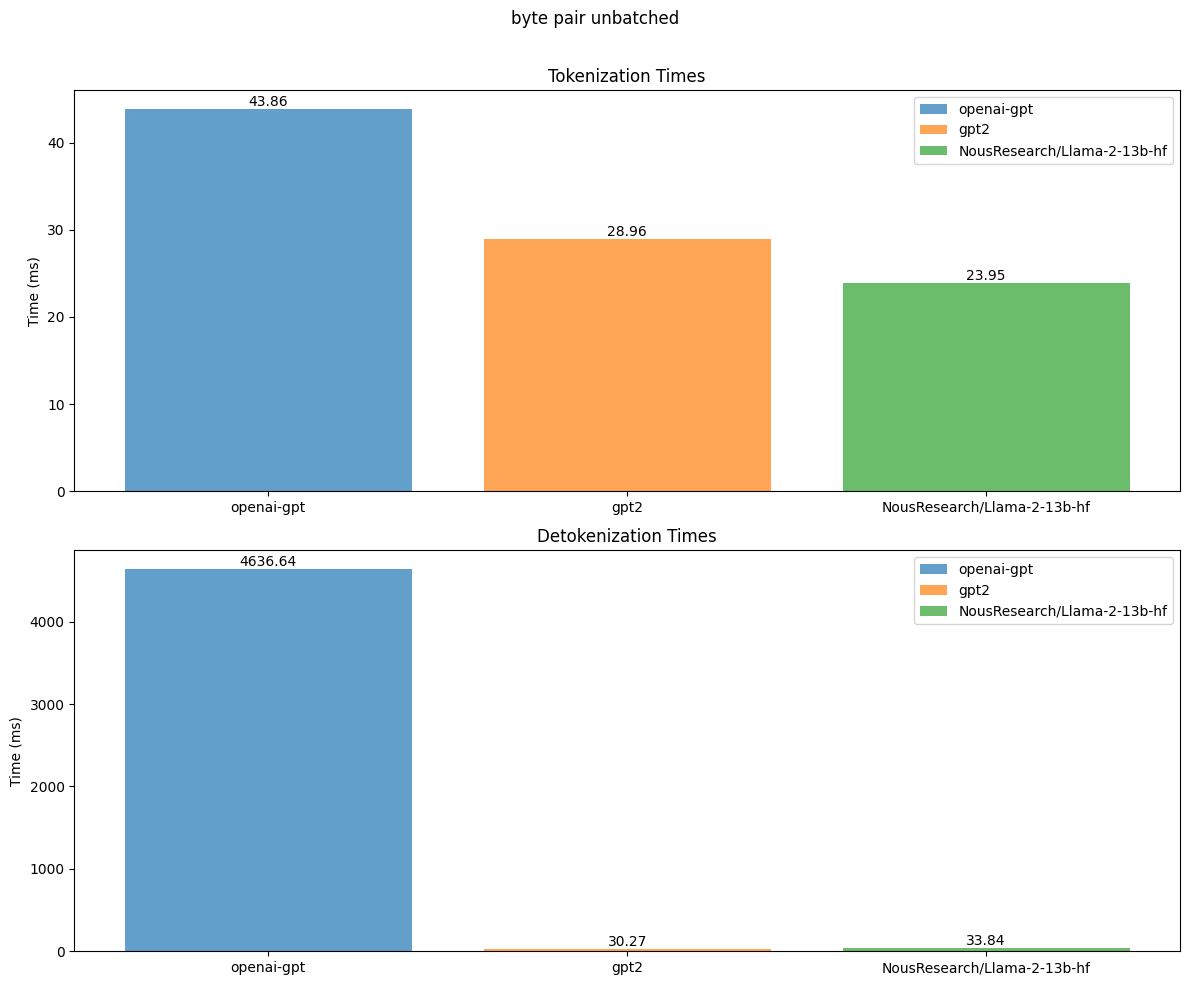

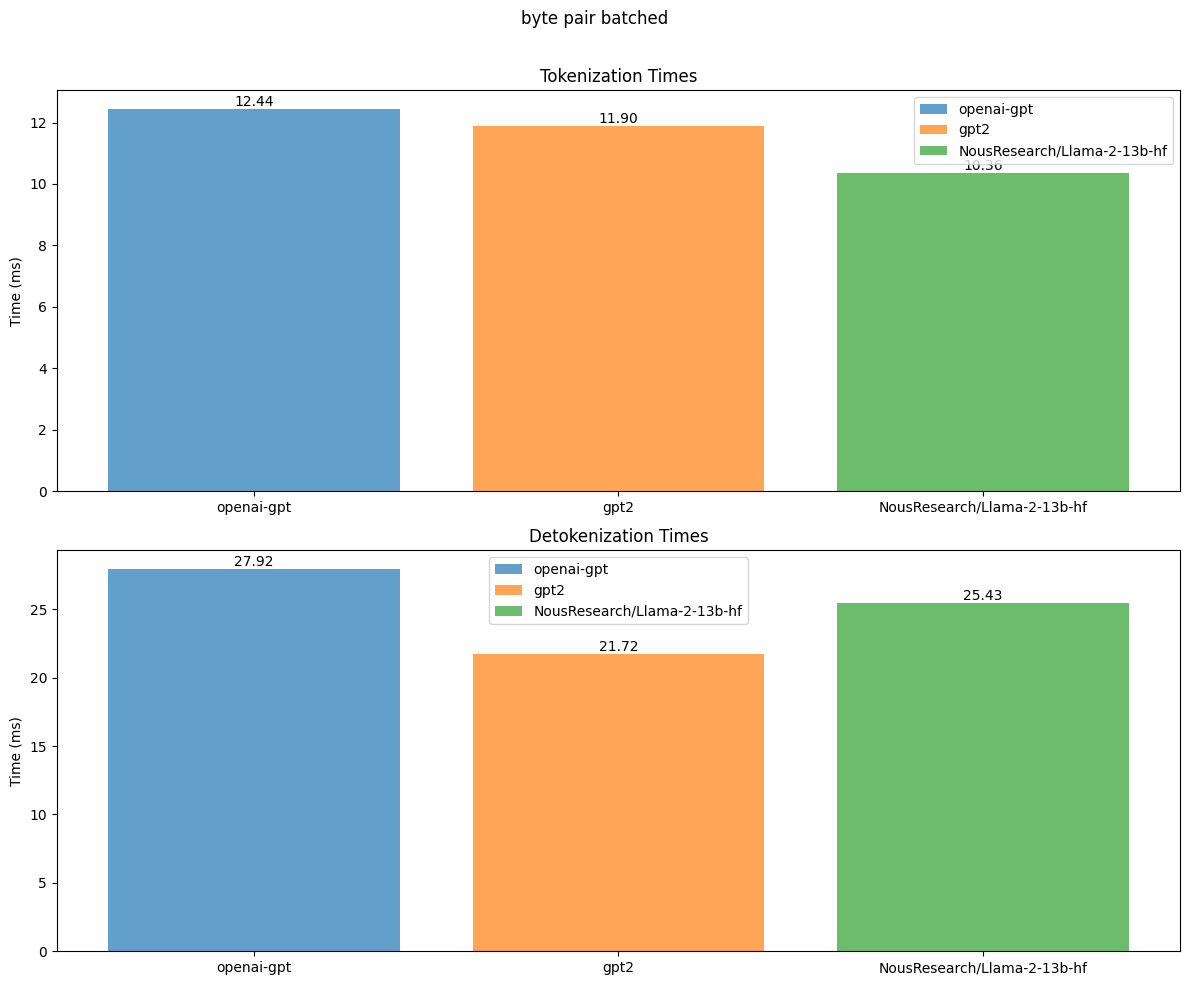

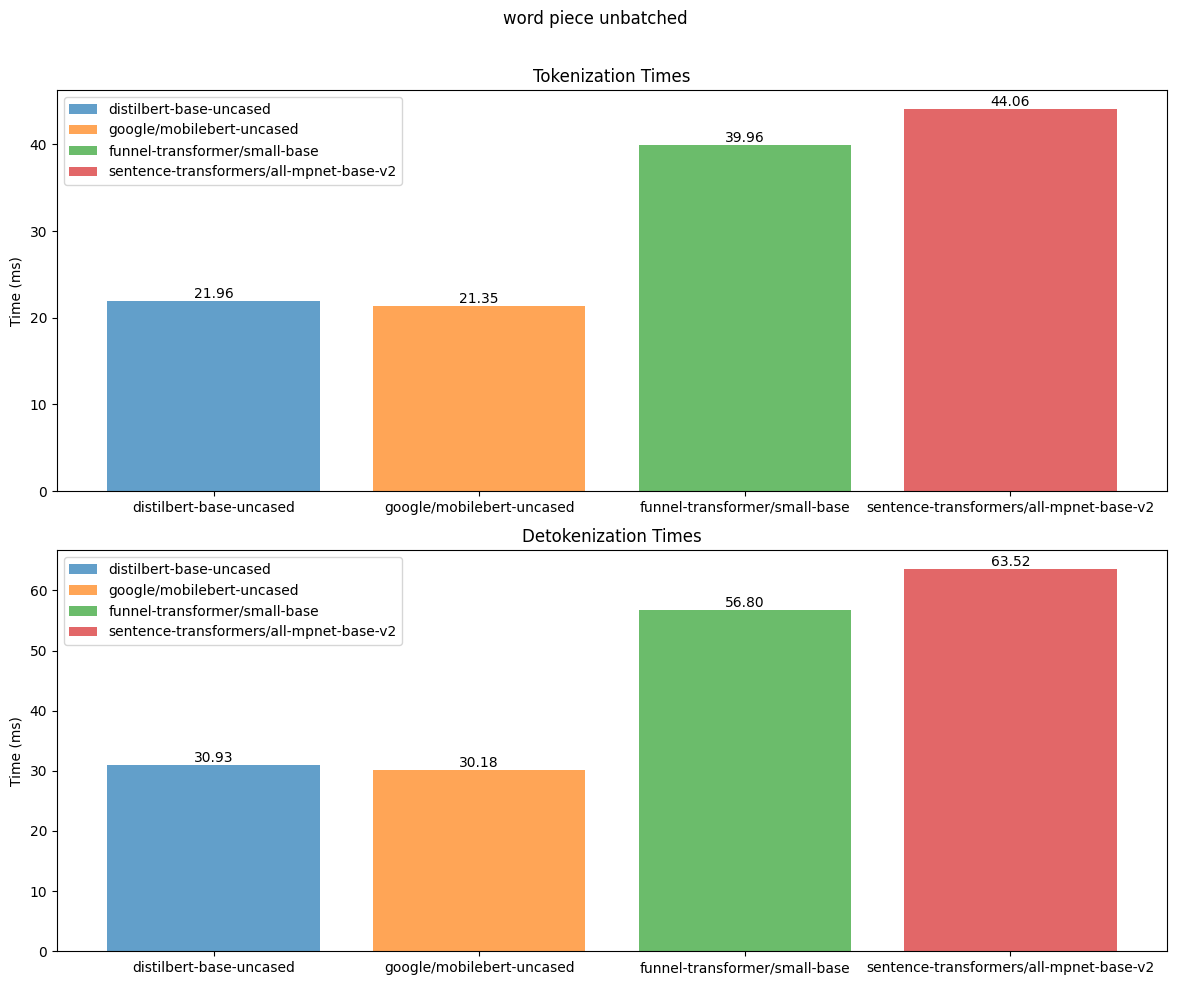

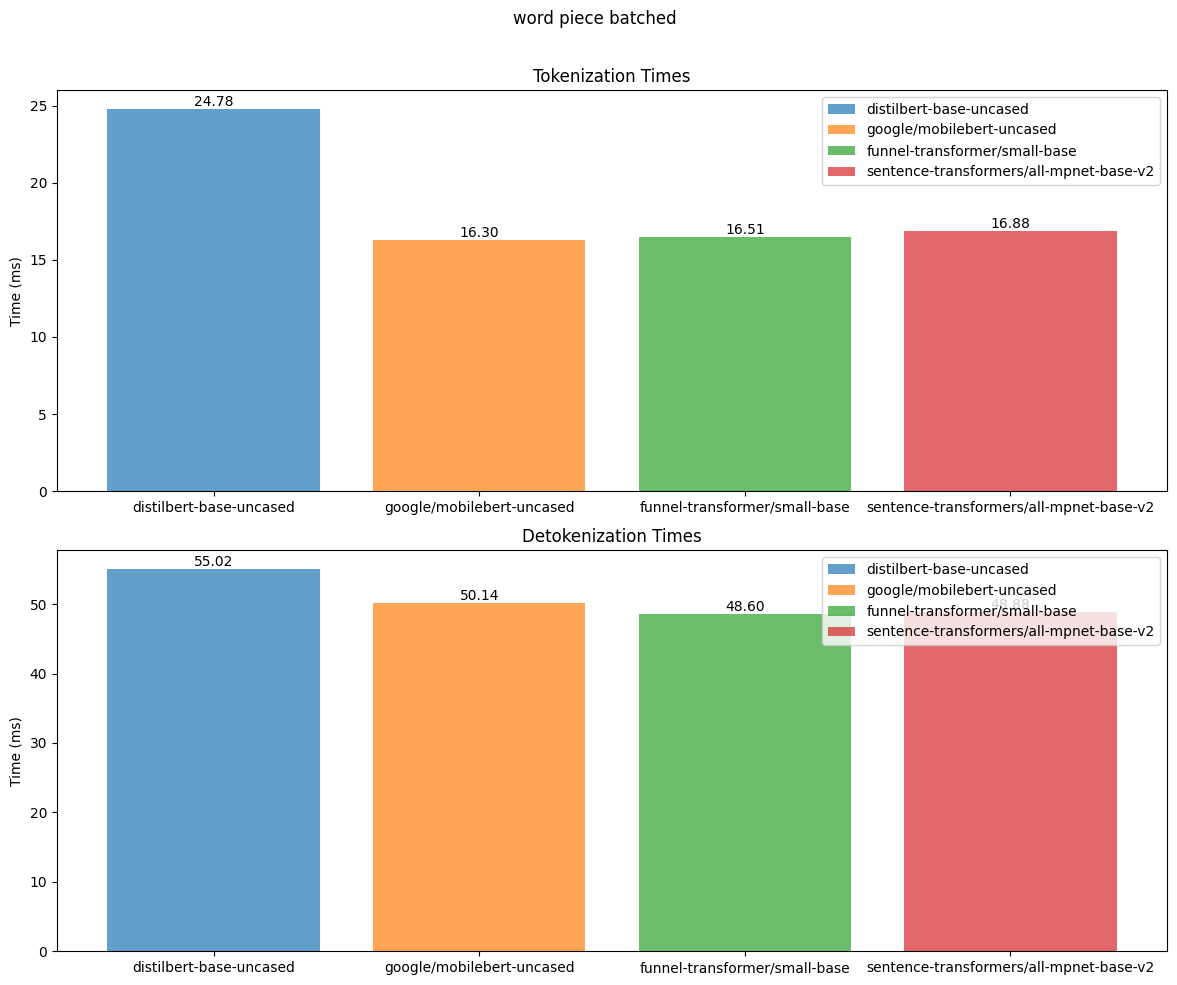

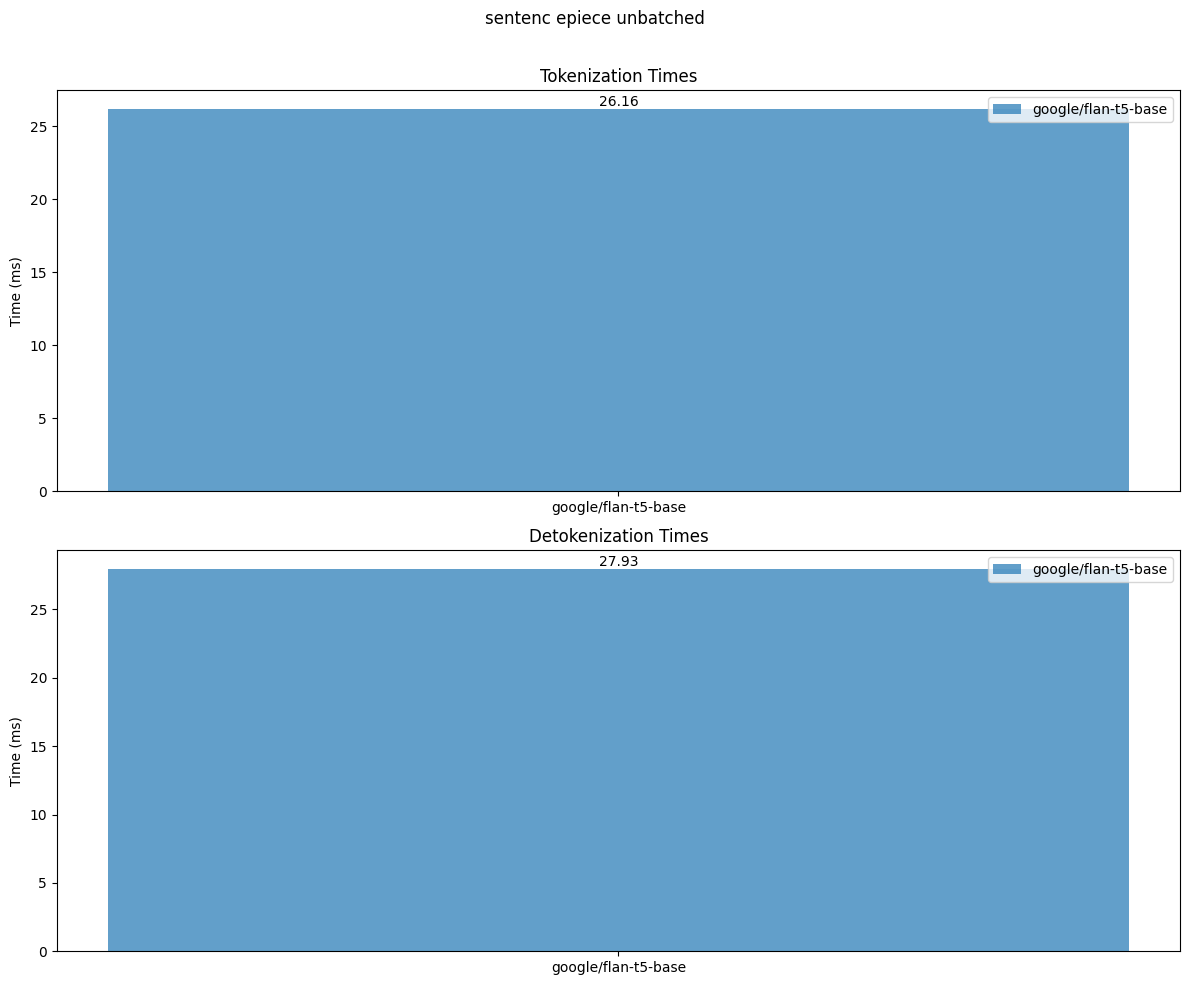

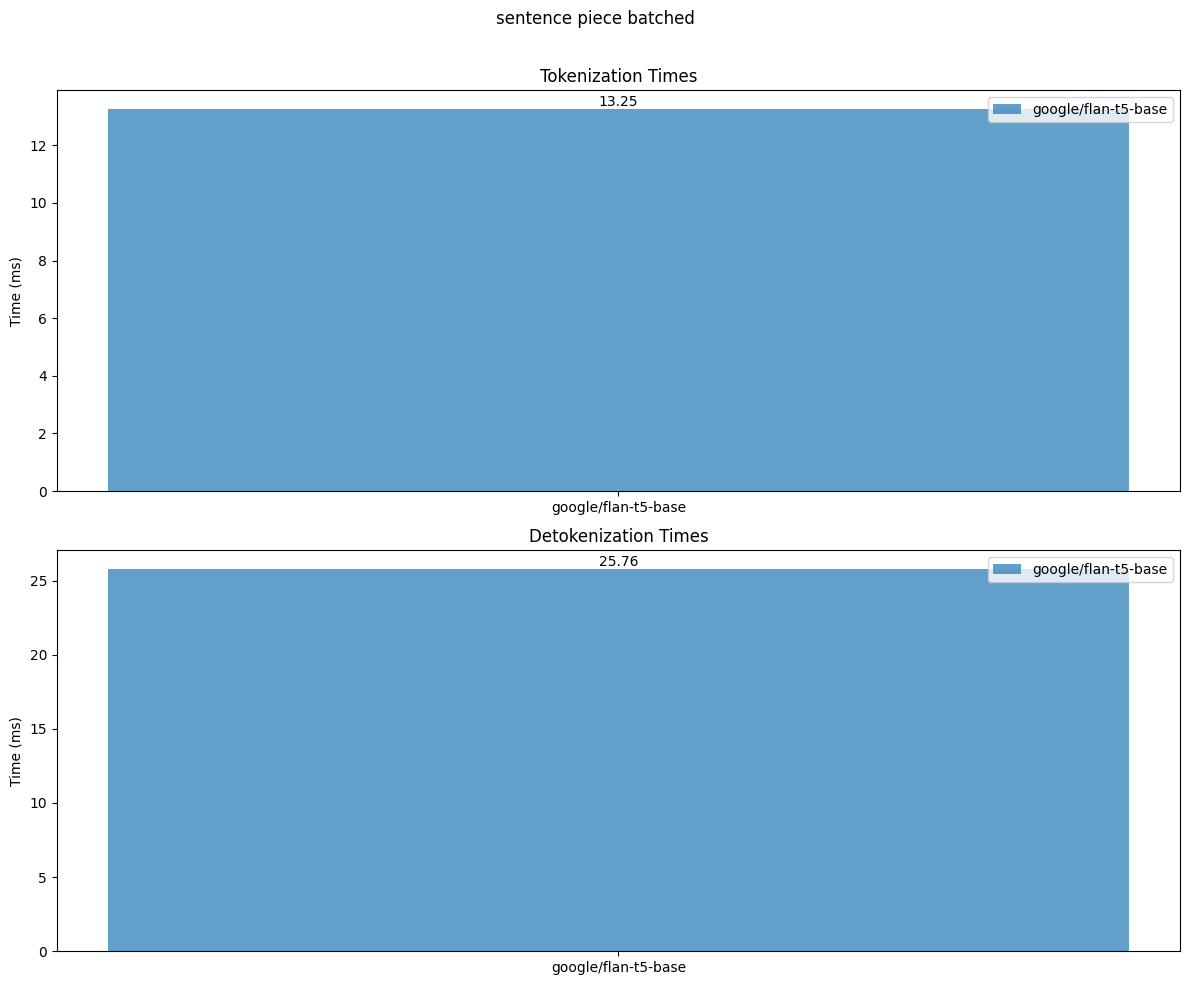

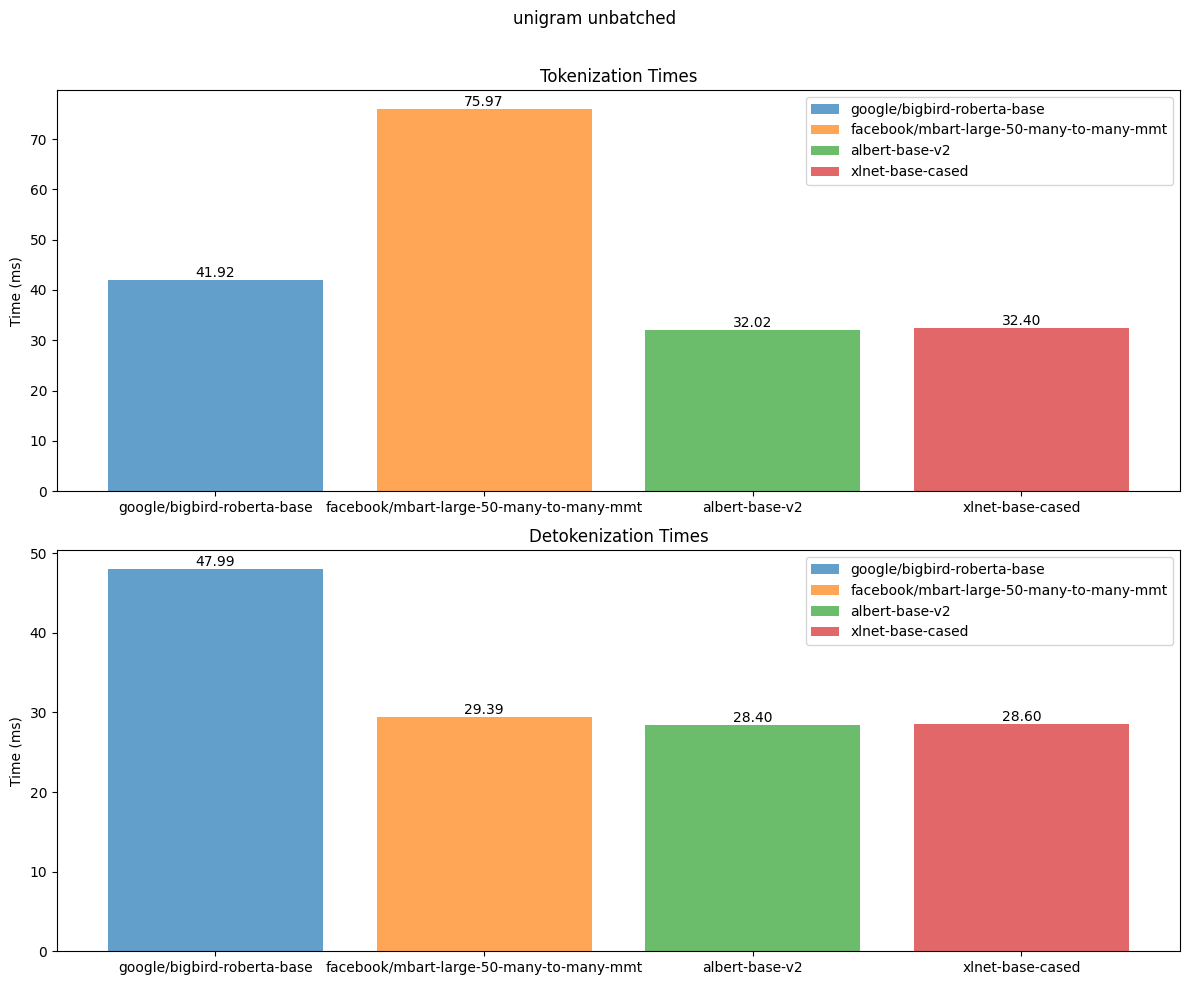

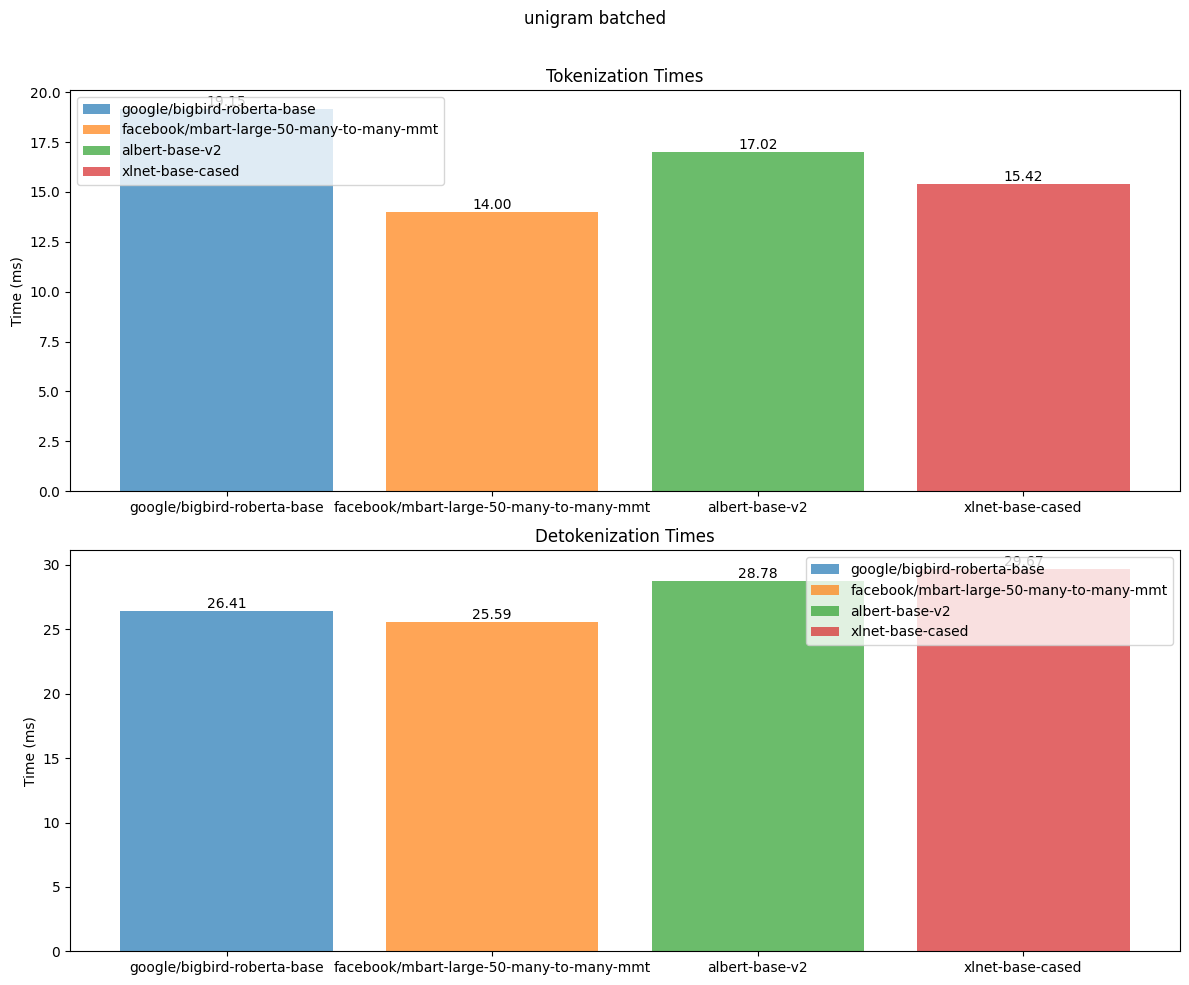

In [12]:
import matplotlib.pyplot as plt


def plot_dict(data_dict, title=''):
    # Extract method names and labels for the x-axis
    methods = list(data_dict.keys())
    x_labels = [f"{method}" for method in methods]

    # Create subplots for tokenization and detokenization times
    fig, axs = plt.subplots(2, figsize=(12, 10))
    fig.suptitle(title)

    for key, value in data_dict.items():
        if key == "method":
            continue

        # Plot tokenization times
        tokenization_time = value.get('Tokenization', 0.0)
        axs[0].bar(key, tokenization_time, label=key, alpha=0.7)

        # Plot detokenization times
        detokenization_time = value.get('Detokenization', 0.0)
        axs[1].bar(key, detokenization_time, label=key, alpha=0.7)

        # Add text labels on top of the bars
        axs[0].annotate(f'{tokenization_time:.2f}', (key, tokenization_time),
                            ha='center', va='bottom')
        axs[1].annotate(f'{detokenization_time:.2f}', (key, detokenization_time),
                            ha='center', va='bottom')

    # Set labels and titles
    axs[0].set_ylabel('Time (ms)')
    axs[0].set_title('Tokenization Times')
    axs[0].legend()

    axs[1].set_ylabel('Time (ms)')
    axs[1].set_title('Detokenization Times')
    axs[1].legend()

    # Show the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    print("\n\n\n\n")

plot_dict(byte_pair_timing_unbatched, "byte pair unbatched")
plot_dict(byte_pair_timing_batched, "byte pair batched")
plot_dict(word_piece_timing_unbatched, "word piece unbatched")
plot_dict(word_piece_timing_batched, "word piece batched")
plot_dict(sentence_piece_timing_unbatched, "sentenc epiece unbatched")
plot_dict(sentence_piece_timing_batched, "sentence piece batched")
plot_dict(unigram_timing_unbatched, "unigram unbatched")
plot_dict(unigram_timing_batched, "unigram batched")